## Environment setup and data pre-processing

In [48]:
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ModelCheckpoint
from keras.layers import *
from keras.models import Sequential
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf

#from config import *

#df = pd.read_csv("/content/XAUUSDM15.csv", names=['timestamp','open','high','low','close','volume'])
column= ['time','open','high','low','close','volume']
df = pd.read_csv('https://github.com/vietnc/ML/raw/main/XAUUSD15.csv', sep='\t', names=column)
#print(df.count())

# Rename bid OHLC columns
#df.rename(columns={'Time': 'timestamp', 'Open': 'open', 'Close': 'close',
#                   'High': 'high', 'Low': 'low', 'Close': 'close', 'Volume': 'volume'}, inplace=True)
#date_time = pd.to_datetime(df.pop('time'),format='%Y-%m-%d %H:%M')
df['time']= pd.to_datetime(df['time'],format='%Y-%m-%d %H:%M')
date_time = df['time']
df.set_index('time', inplace=True)
#df = df.astype(float)

# Add additional features
df['momentum'] = df['volume'] * (df['close'] - df['open'])
df['Wy'] = df['high'] - df['low']
df['Wx'] = df['close'] - df['open']
df['MA34'] = df['close'].rolling(3).mean().fillna(0)
df['MA89'] = df['close'].rolling(89).mean().fillna(0)
df['pos'] = df['close'] - df['MA34'] + 3*(df['MA34'] -df['MA89'])
#previous movement
df['pre'] = df['close'].shift(1).fillna(0) - df['open'].shift(1).fillna(0)


(-71.89699999999993, 54.63000000000011, 0.11999999999989086, 83.15999999999985)

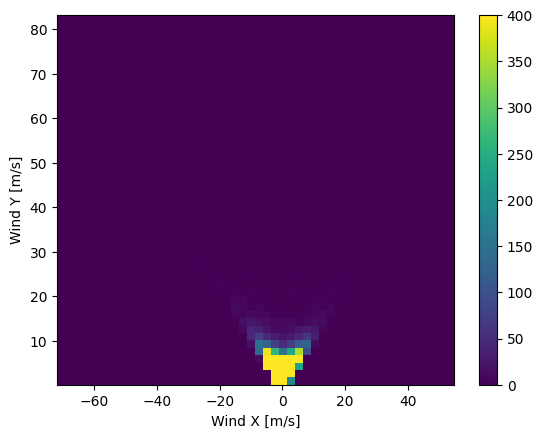

In [49]:
plt.hist2d(df['Wx'], df['Wy'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Wind X [m/s]')
plt.ylabel('Wind Y [m/s]')
ax = plt.gca()
ax.axis('tight')

In [50]:
timestamp_s = date_time.map(pd.Timestamp.timestamp)
day = 24*60*60
year = (365.2425)*day

df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Text(0.5, 1.0, 'Time of day signal')

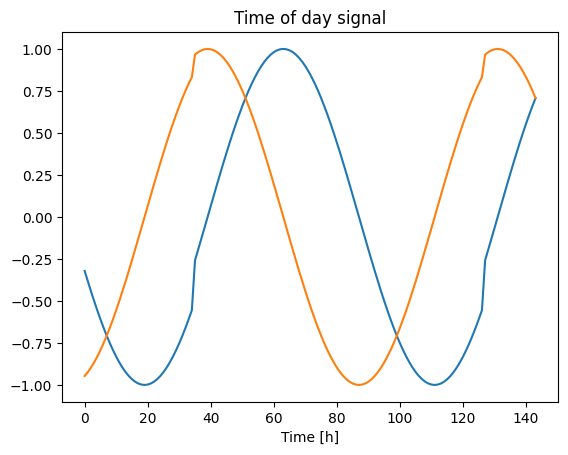

In [9]:
plt.plot(np.array(df['Day sin'])[:144])
plt.plot(np.array(df['Day cos'])[:144])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

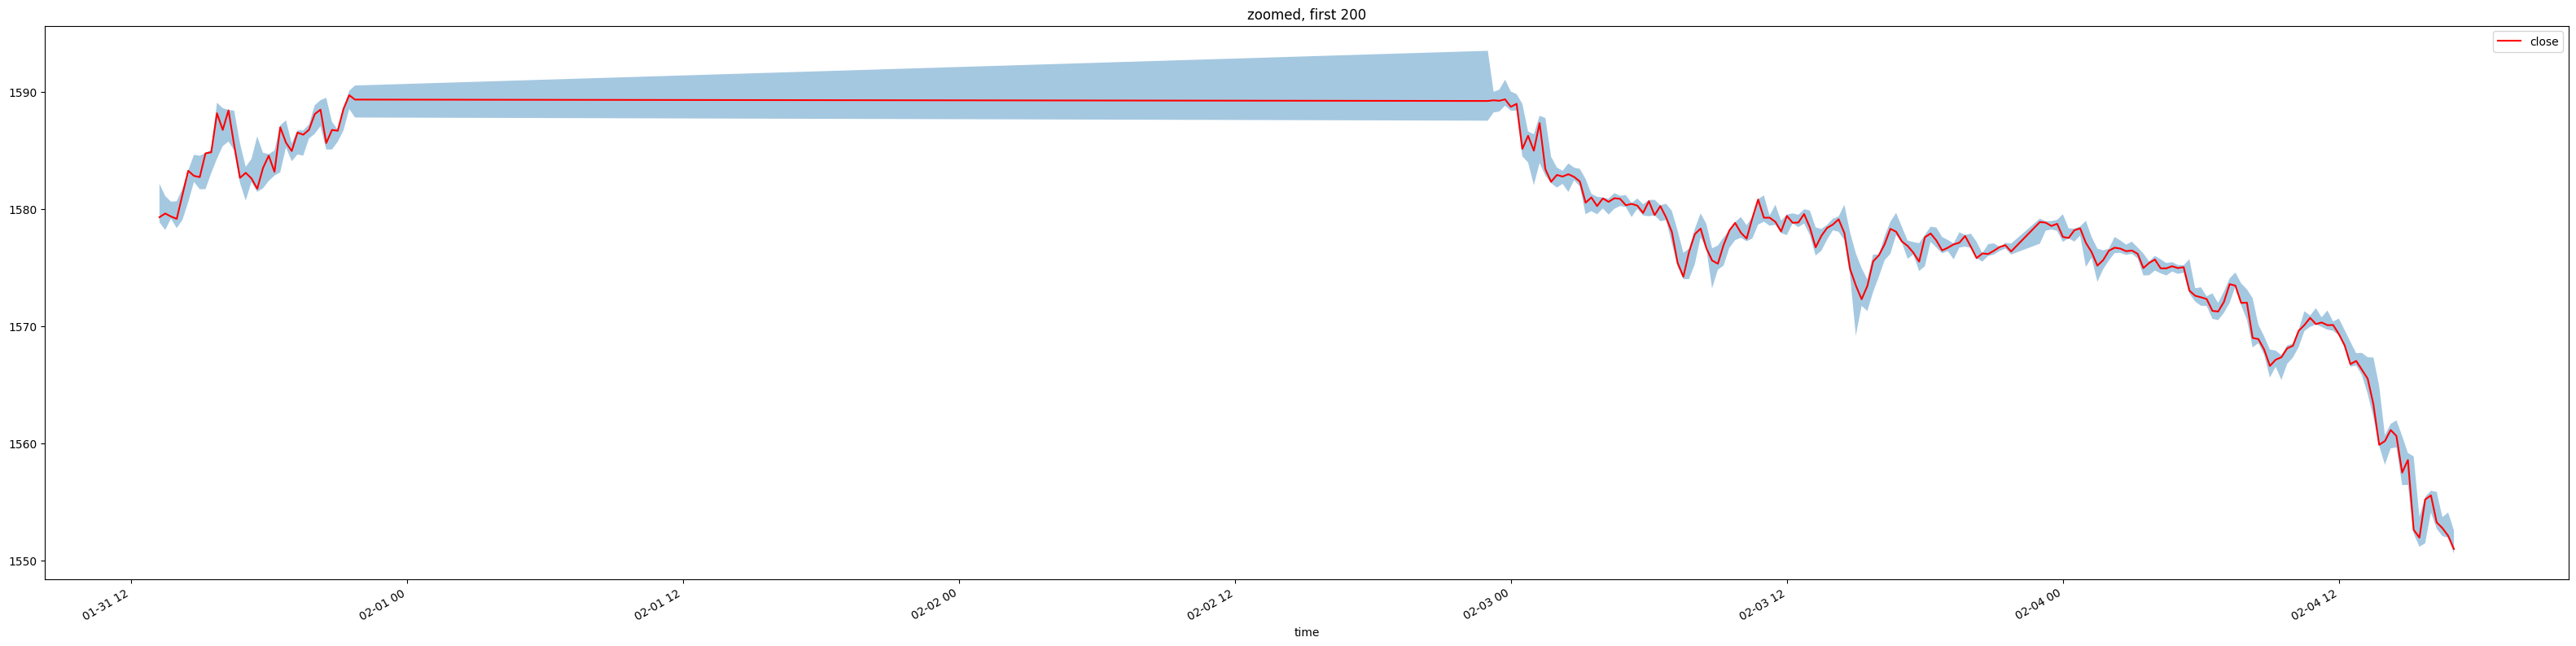

In [51]:

p = df[:200].copy()
ax = p.plot( y='close', c='red', figsize=(40,10))
index = [str(item) for item in p.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('zoomed, first 200')
plt.show()

Setup training dataset

In [52]:
dataset = df.filter(['close'])
training = int(np.ceil(len(dataset) * .90))
print(training)

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

train_data = scaled_data[0:int(training), :]
# prepare feature and labels
x_train = []
y_train = []

for i in range(60, len(train_data)):
	x_train.append(train_data[i-60:i, 0])
	y_train.append(train_data[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))


90000


In [151]:
print(dataset)


[[0.13087368 0.12397015 0.13242412 ... 0.02653494 0.74992704 0.9330548 ]
 [0.1290747  0.12289739 0.13174999 ... 0.03806025 0.75000465 0.93301   ]
 [0.12942421 0.12239909 0.13275278 ... 0.05156362 0.75008225 0.9329652 ]
 ...
 [0.88444316 0.87914515 0.89301336 ... 0.7211443  0.9587724  0.30118376]
 [0.88286006 0.8793721  0.89298236 ... 0.6913417  0.9587368  0.30110157]
 [0.8847033  0.8807335  0.89480746 ... 0.66071975 0.95870113 0.30101937]]


In [53]:

model = Sequential()
model.add(LSTM(units=64,
                            return_sequences=True,
                            input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=64))
model.add(Dense(32))
model.add(Dropout(0.5))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 60, 64)            16896     
                                                                 
 lstm_3 (LSTM)               (None, 64)                33024     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 52033 (203.25 KB)
Trainable params: 52033 (203.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model creation

In [54]:

model.compile(optimizer='adam',
              loss='mean_squared_error')
history = model.fit(x_train,
                    y_train,
                    epochs=3)

Epoch 1/3
2811/2811 [==============================] - 177s 61ms/step - loss: 0.0015
Epoch 2/3
2811/2811 [==============================] - 164s 59ms/step - loss: 4.1588e-04
Epoch 3/3
2811/2811 [==============================] - 165s 59ms/step - loss: 4.0800e-04


## Benchmark

In [56]:
test_data = scaled_data[training - 60:, :]
x_test = []
y_test = dataset[training:]
for i in range(60, len(test_data)):
	x_test.append(test_data[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# predict the testing data
predictions = model.predict(x_test)

predictions = predictions.reshape((predictions.shape[0], predictions.shape[1]))
scaler.inverse_transform(predictions)
# evaluation metrics
print(predictions)

313/313 [==============================] - 7s 21ms/step
[[0.5368358]
 [0.5368995]
 [0.5374281]
 ...
 [0.8616717]
 [0.8617419]
 [0.862126 ]]


In [57]:
predictions = predictions[:, 0]
print(y_test)
print(predictions)
mse =  mean_squared_error(y_test, predictions)
print("MSE", mse)
print("RMSE", np.sqrt(mse))


                        close
time                         
2023-11-20 21:45:00  1977.774
2023-11-20 23:00:00  1979.735
2023-11-20 23:15:00  1980.305
2023-11-20 23:30:00  1980.735
2023-11-20 23:45:00  1981.195
...                       ...
2024-04-25 03:45:00  2313.075
2024-04-25 04:00:00  2314.064
2024-04-25 04:15:00  2312.565
2024-04-25 04:30:00  2314.348
2024-04-25 04:45:00  2315.198

[10000 rows x 1 columns]
[0.5368358 0.5368995 0.5374281 ... 0.8616717 0.8617419 0.862126 ]
MSE 4438447.441287454
RMSE 2106.7623124803267


                         open      high       low     close  volume  momentum  \
time                                                                            
2020-01-31 13:15:00  1581.025  1582.138  1578.848  1579.285      15    -26.10   
2020-01-31 13:30:00  1579.275  1581.098  1578.198  1579.605      15      4.95   
2020-01-31 13:45:00  1579.615  1580.615  1579.165  1579.345      15     -4.05   
2020-01-31 14:00:00  1579.295  1580.655  1578.355  1579.145      15     -2.25   
2020-01-31 14:15:00  1579.145  1581.728  1579.055  1581.215      15     31.05   

                        Wy    Wx         MA34  MA89          pos   pre  \
time                                                                     
2020-01-31 13:15:00  3.290 -1.74     0.000000   0.0  1579.285000  0.00   
2020-01-31 13:30:00  2.900  0.33     0.000000   0.0  1579.605000 -1.74   
2020-01-31 13:45:00  1.450 -0.27  1579.411667   0.0  4738.168333  0.33   
2020-01-31 14:00:00  2.300 -0.15  1579.365000   0.0  4737.8750

<ipython-input-61-f12f4f88dd56>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = predictions


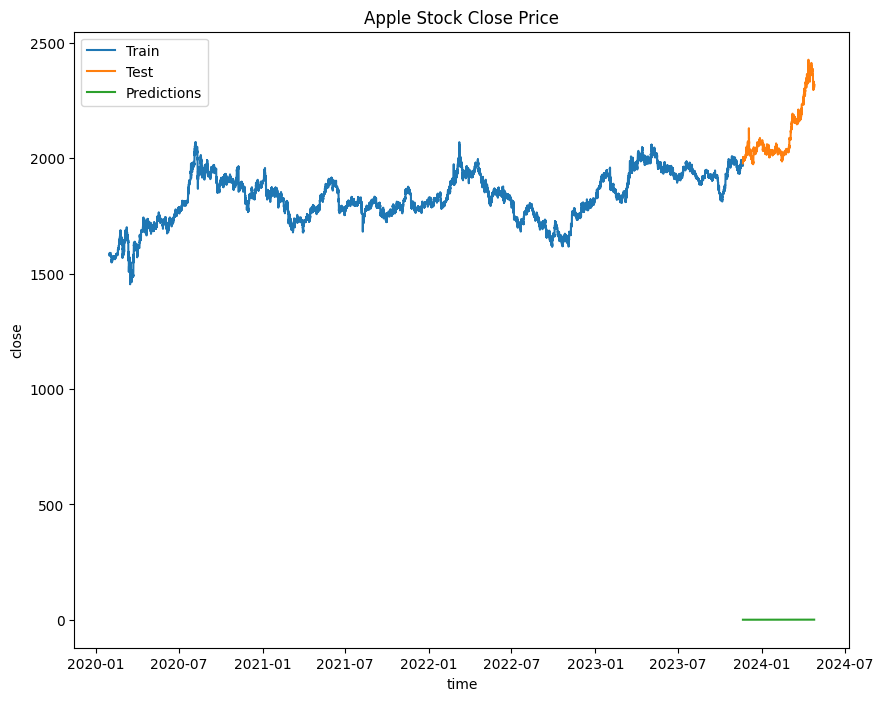

In [61]:
train = df[:training]
test = df[training:]
test['Predictions'] = predictions
print(df.head())
plt.figure(figsize=(10, 8))
plt.plot( train['close'])
plt.plot( test[['close', 'Predictions']])
plt.title('Apple Stock Close Price')
plt.xlabel('time')
plt.ylabel("close")
plt.legend(['Train', 'Test', 'Predictions'])


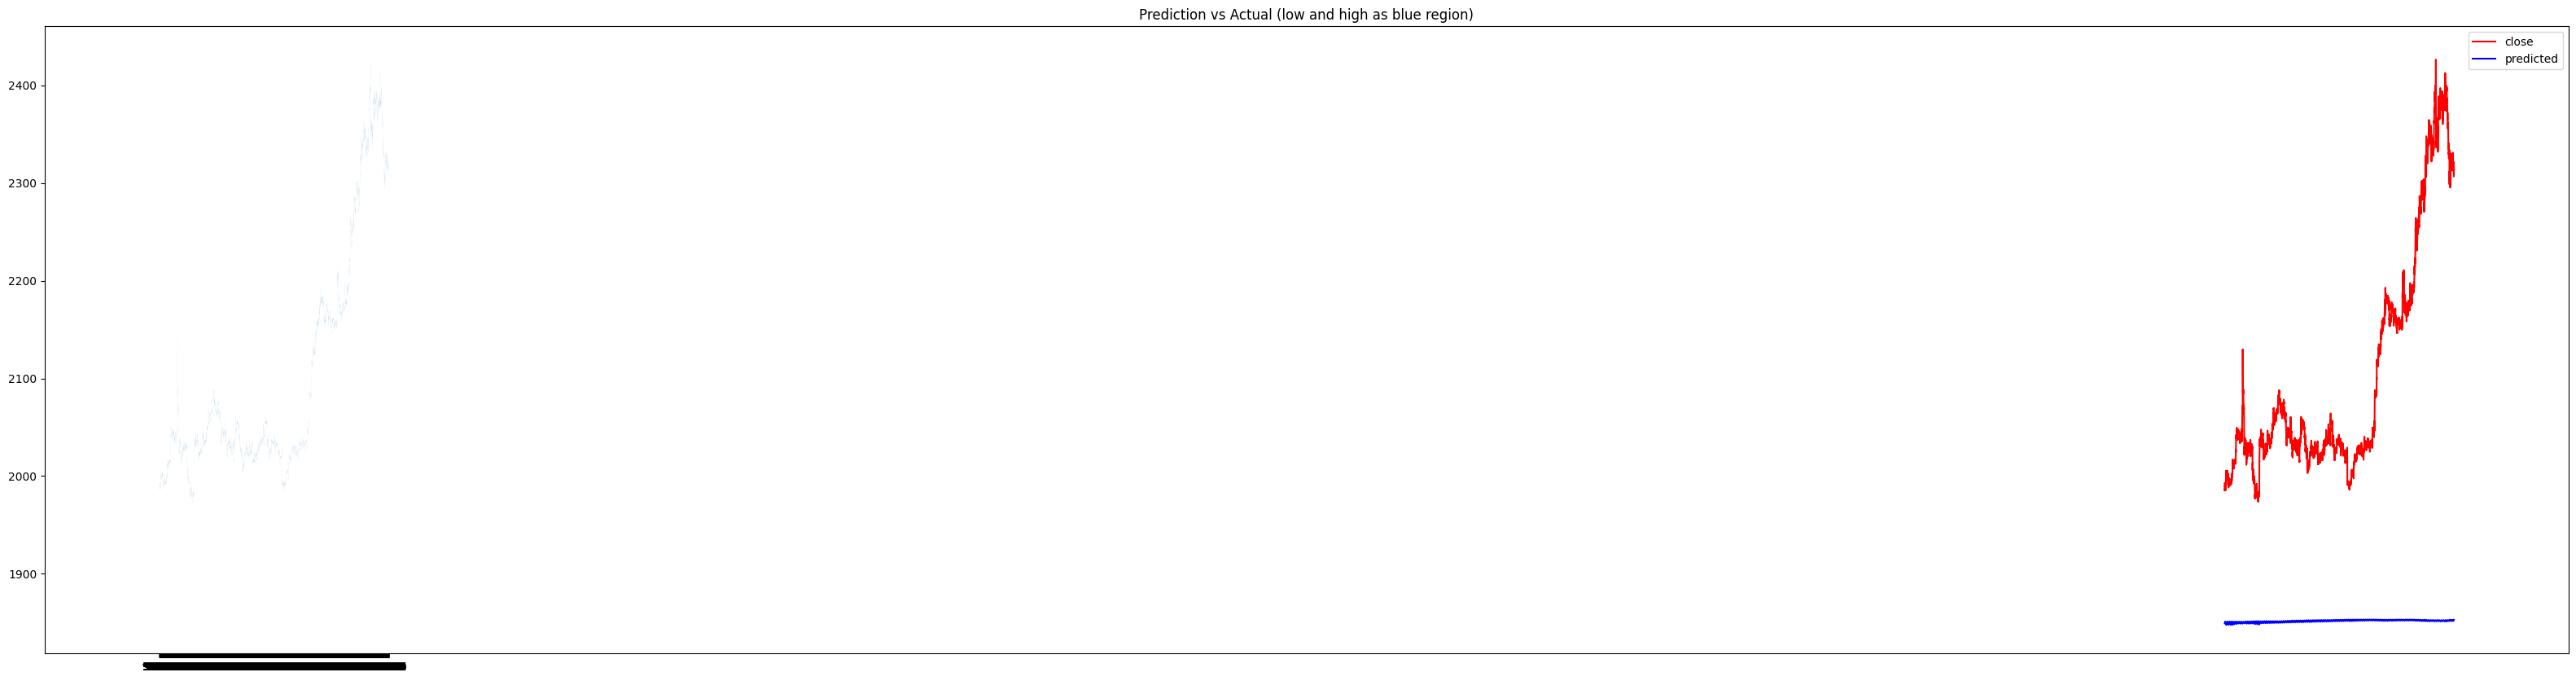

<Figure size 1000x1000 with 0 Axes>

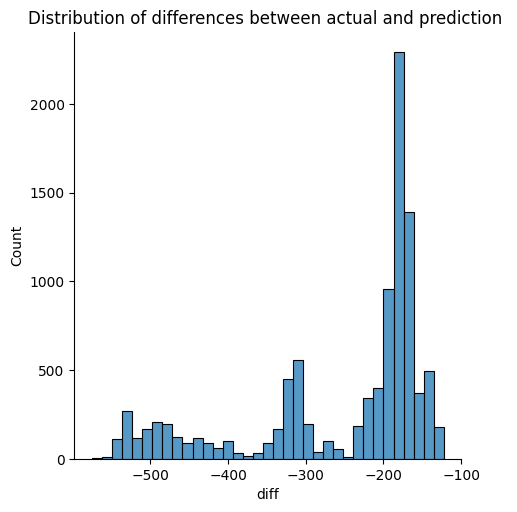

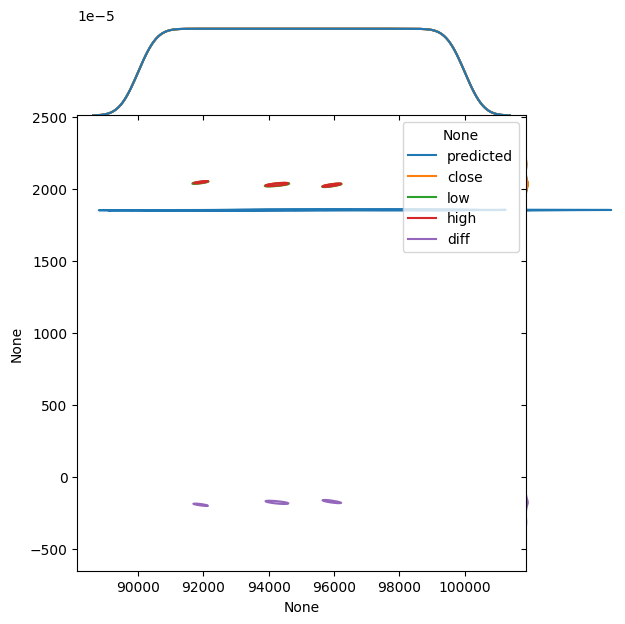

MSE :  77601.17275264153
MAE :  252.68925703787707


count    9991.000000
mean     -252.689257
std       117.263329
min      -575.222900
25%      -314.513184
50%      -190.227905
75%      -174.339294
max      -122.211182
Name: diff, dtype: float64

In [161]:
ax = predictions.plot( y='close', c='red', figsize=(40, 10))
ax = predictions.plot( y='predicted', c='blue', figsize=(40, 10), ax=ax)
index = [str(item) for item in predictions.index]
plt.fill_between(x=index, y1='low', y2='high', data=p, alpha=0.4)
plt.title('Prediction vs Actual (low and high as blue region)')
plt.show()

predictions['diff'] = predictions['predicted'] - predictions['close']
plt.figure(figsize=(10, 10))
sns.displot(predictions['diff']);
plt.title('Distribution of differences between actual and prediction ')
plt.show()

g = sns.jointplot(data=predictions, kind="kde", space=0)
plt.title('Distributtion of error and price')
plt.show()

# predictions['correct'] = (predictions['predicted'] <= predictions['high']) & (predictions['predicted'] >= predictions['low'])
# sns.factorplot(data=predictions, x='correct', kind='count')

print("MSE : ", mean_squared_error(predictions['predicted'].values, predictions['close'].values))
print("MAE : ", mean_absolute_error(predictions['predicted'].values, predictions['close'].values))
predictions['diff'].describe()